# Over-estimation bias with DDPG and TD3 on  LunarLander

IAR - Groupe 2  
LAHBIB Yassin 28718491  
LEBRETON Guillaume 21109566 

In [28]:
#Installation des dépendances

import gymnasium as gym
import numpy as np
import torch
import gc
import matplotlib.pyplot as plt
import os 
import pandas as pd

from stable_baselines3 import DDPG, TD3
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import TensorBoardOutputFormat
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor

# DDPG

In [ ]:
# env = make_vec_env("LunarLanderContinuous-v3", n_envs=16)

# The noise objects for DDPG
# n_actions = env.action_space.shape[-1]
# action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=0, device="cuda", tensorboard_log="runs/lunarlander")

# TD3

In [ ]:
# td3_env = make_vec_env("LunarLanderContinuous-v3", n_envs=16)

# td3_n_actions = td3_env.action_space.shape[-1]
# td3_action_noise = NormalActionNoise(mean=np.zeros(td3_n_actions), sigma=0.1 * np.ones(td3_n_actions))

# td3_model = TD3("MlpPolicy", td3_env, action_noise=td3_action_noise, verbose=0, device="cuda", tensorboard_log="runs/lunarlander")

# Visu de l'agent avant entrainement

In [6]:
# befor_env = gym.make("LunarLanderContinuous-v3", render_mode="human")
# obs, info = befor_env.reset()


# for i in range(1000):
#     action, _states = model.predict(obs)
#     obs, rewards, dones, truncated,  info = befor_env.step(action)
#     if dones:
#         obs, info = befor_env.reset()
    

# Variable stockant les résulats

In [19]:
NB_SEED = 5
mc_ddpg_valeur = [ [] for _ in range(NB_SEED)]
mc_td3_valeur = [ [] for _ in range(NB_SEED)]
ddpg_valeur = [ [] for _ in range(NB_SEED)]
td3_valeur = [ [] for _ in range(NB_SEED)] 
steps = [ [] for _ in range(NB_SEED)] 



# Callback

In [3]:
# ensemble de fonction appelées a chaque etape de l'entrainement de l'agent
class CustomCallback(BaseCallback):
    """ Permettant d'afficher les Q veleurs pendant l'entrainement """
    
    def __init__(self, check_freq, seed_curr, n_simulation, env_id, model_type, verbose=1, batch_size=64, gamma=0.99):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.batch_size = batch_size
        self.tb_writer = None
        self.n_simulation = n_simulation
        self.gamma = gamma
        self.seed_curr = seed_curr
        self.env_id = env_id
        self.model_type = model_type

    def _on_training_start(self):
        for fmt in self.logger.output_formats:
            if isinstance(fmt, TensorBoardOutputFormat):
                self.tb_writer = fmt.writer
                break
        self.eval_env = gym.make(self.env_id)


    def _afficher_qvalue(self):
            if self.num_timesteps % self.check_freq == 0:
                replay_buffer = self.model.replay_buffer

                if self.model.replay_buffer.size() < self.batch_size:
                    q_value_mean = 0.0
                    q_value_rb_mean = 0.0

                else:
                    batch = replay_buffer.sample(self.batch_size)
                    with torch.no_grad():

                        # enregistre la moyenne des q valeur selon l'action du replay buffer
                        q_value_rb = self.model.policy.critic(batch.observations, batch.actions) 
                        

                        if self.model_type == "ddpg":
                            q_value_rb = q_value_rb[0]
                        if self.model_type == "td3":
                            q_value_rb = torch.min(q_value_rb[0], q_value_rb[1]) 
                        q_value_rb_mean = q_value_rb.squeeze().mean()
                        q_value_rb_mean = q_value_rb_mean.item()
                        
                        # enregistre la moyenne des q valeur selon l'action prédit par l'actor
                        action_actor = self.model.policy.actor(batch.observations)
                        q_value = self.model.policy.critic(batch.observations, action_actor)

                        if len(q_value) == 1: #dans le cas de DDPG
                            q_value = q_value[0]
                        else: 
                            q_value = torch.min(q_value[0], q_value[1])
                        q_value_mean = q_value.squeeze().mean()
                        q_value_mean = q_value_mean.item()
                
                if self.model_type == "ddpg":
                    self.logger.record("q_valueDDPG", q_value_mean)
                    ddpg_valeur[self.seed_curr].append(q_value_mean)
                if self.model_type == "td3":
                    self.logger.record("q_valueTD3", q_value_mean)
                    td3_valeur[self.seed_curr].append(q_value_mean)

                if self.model_type == "ddpg": #Pour ne pas doubler taille de steps ave ceux de td3 aussi
                    steps[self.seed_curr].append(self.num_timesteps)

                # afficher les deux courbes sur le meme graphe dans tensorboard
                self.tb_writer.add_scalars(
                    "q_values",
                    {"q_value_rb_mean": q_value_rb_mean, "q_value_mean": q_value_mean},
                    self.num_timesteps,
                )


    def p(self, n, exposant):
        """fonction puissance"""
        return n**exposant

    def _estimation_qvalue_monteCarlo(self):
        """Permet d'afficher l'estimation des Qvaleur pendant l'entrainement"""
        if self.num_timesteps % self.check_freq == 0:
            if self.model.replay_buffer.size() < self.batch_size:
                G_mean = 0.0
                G_std = 0.0
            else:
                all_G = [] #de taille self.n_simulation
            
                for _ in range(self.n_simulation):
                    obs, info = self.eval_env.reset()  # reset classique
                    done = False
                    reward_ep = 0.0
                    j = 0

                    while not done:
                        with torch.no_grad():
                            # Politique déterministe
                            action, _ = self.model.predict(obs, deterministic=True)
                            obs, reward, terminated, truncated, info = self.eval_env.step(action)
                            done = terminated or truncated
                            reward_ep += (self.gamma ** j) * reward
                            j += 1

                    all_G.append(reward_ep)

                G = np.array(all_G)
                G_mean = G.mean()
                G_std = G.std()

            self.logger.record("monteCarlo/mean", G_mean)
            self.logger.record("monteCarlo/std", G_std)

            self.tb_writer.add_scalars(
                    "q_values",
                    {"monteCarlo_mean": G_mean},
                    self.num_timesteps,
                )
            if self.model_type == "ddpg":
                mc_ddpg_valeur[self.seed_curr].append(G_mean)
            if self.model_type == "td3":
                mc_td3_valeur[self.seed_curr].append(G_mean)

    def _on_training_end(self):
        self.eval_env.close()

    
    #appelée apres chaque env.step()
    def _on_step(self):
        self._afficher_qvalue()
        self._estimation_qvalue_monteCarlo()

        self.logger.dump(self.num_timesteps) #permet de faire commencer les valeurs a 0 dans tensorboard

        return True


# Création d'env vect monitoré

In [ ]:
# Pour optimiser les performances sur GPU
torch.backends.cudnn.benchmark = True


def make_monitored_env(env_id, n_envs=1, log_dir="./logs"):
    os.makedirs(log_dir, exist_ok=True)

    vec_env = make_vec_env(env_id, n_envs=n_envs, monitor_dir=log_dir)
    vec_env = VecMonitor(vec_env, filename=os.path.join(log_dir, "monitor.csv"))
    
    return vec_env


# Simulations

In [ ]:
for seed_curr in range (NB_SEED):

    print(f"=== Seed {seed_curr} ===")

    # Fixer les seeds pour PyTorch et numpy
    np.random.seed(seed_curr)
    torch.manual_seed(seed_curr)

    log_dir_ddpg = f"./logs/ddpg_seed_{seed_curr}"
    log_dir_td3 = f"./logs/td3_seed_{seed_curr}"

    env = make_monitored_env("LunarLanderContinuous-v3", n_envs=4, log_dir=log_dir_ddpg)
    env.seed(seed_curr)
    td3_env = make_monitored_env("LunarLanderContinuous-v3", n_envs=4, log_dir=log_dir_td3)
    td3_env.seed(seed_curr)

    # Crée un bruit différent pour chaque seed
    n_actions = env.action_space.shape[0]
    action_noise_ddpg = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1*np.ones(n_actions))
    action_noise_td3 = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1*np.ones(n_actions))

    model = DDPG("MlpPolicy", env, action_noise=action_noise_ddpg, verbose=0, device="cuda", tensorboard_log="runs/lunarlander", batch_size=256, learning_rate=1e-3)
    td3_model = TD3("MlpPolicy", td3_env, action_noise=action_noise_td3, verbose=0, device="cuda", tensorboard_log="runs/lunarlander", batch_size=256, learning_rate=1e-3)    

    qvalue_callback_1 = CustomCallback(check_freq=250, seed_curr=seed_curr, n_simulation=10, env_id="LunarLanderContinuous-v3", model_type="ddpg")
    model.learn(total_timesteps=300000, progress_bar=True, tb_log_name="ddpg", callback=qvalue_callback_1)
    model.save(f"ddpg_LunarLanderContinuous-v3_seed_{seed_curr}")


    qvalue_callback_2 = CustomCallback(check_freq=250, seed_curr=seed_curr, n_simulation=10, env_id="LunarLanderContinuous-v3", model_type="td3")
    td3_model.learn(total_timesteps=300000, progress_bar=True, tb_log_name="td3", callback=qvalue_callback_2)
    td3_model.save(f"td3_LunarLanderContinuous-v3_seed_{seed_curr}")

    env.close()
    td3_env.close()
    qvalue_callback_1.eval_env.close()
    qvalue_callback_2.eval_env.close()

    del model, td3_model, env, td3_env
    gc.collect()
    torch.cuda.empty_cache()

In [10]:
# sauvegarde des resultats dans des fichiers numpy

# Crée le dossier s'il n'existe pas
os.makedirs("./valeurs", exist_ok=True)

np.save("./valeurs/ddpg_valeur.npy", ddpg_valeur)
np.save("./valeurs/td3_valeur.npy", td3_valeur)
np.save("./valeurs/mc_ddpg_valeur.npy", mc_ddpg_valeur)
np.save("./valeurs/mc_td3_valeur.npy", mc_td3_valeur)
np.save("./valeurs/steps.npy", steps)

# Evaluation des Q_Value 

In [ ]:
ddpg_valeur_numpy = np.array(ddpg_valeur)
td3_valeur_numpy = np.array(td3_valeur)
mc_ddpg_valeur_numpy = np.array(mc_ddpg_valeur)
mc_td3_valeur_numpy = np.array(mc_td3_valeur)

ddpg_valeur_numpy_mean = np.mean(ddpg_valeur_numpy, axis=0)
td3_valeur_numpy_mean = np.mean(td3_valeur_numpy, axis=0)
mc_ddpg_valeur_numpy_mean = np.mean(mc_ddpg_valeur_numpy, axis=0)
mc_td3_valeur_numpy_mean = np.mean(mc_td3_valeur_numpy, axis=0)

ddpg_valeur_numpy_std = np.std(ddpg_valeur_numpy, axis=0)
td3_valeur_numpy_std = np.std(td3_valeur_numpy, axis=0)
mc_ddpg_valeur_numpy_std = np.std(mc_ddpg_valeur_numpy, axis=0)
mc_td3_valeur_numpy_std = np.std(mc_td3_valeur_numpy, axis=0)

steps_numpy = steps[0]
x = steps_numpy

plt.plot(x, ddpg_valeur_numpy_mean, label='DDPG Q Valeur', color='blue')
plt.fill_between(x, ddpg_valeur_numpy_mean - ddpg_valeur_numpy_std, ddpg_valeur_numpy_mean + ddpg_valeur_numpy_std, color='blue', alpha=0.2)

plt.plot(x, td3_valeur_numpy_mean, label='TD3 Q Valeur', color='orange')
plt.fill_between(x, td3_valeur_numpy_mean - td3_valeur_numpy_std, td3_valeur_numpy_mean + td3_valeur_numpy_std, color='orange', alpha=0.2)

plt.plot(x, mc_ddpg_valeur_numpy_mean, label='Estimation Monte Carlo DDPG', color='green', linestyle="--")
plt.fill_between(x, mc_ddpg_valeur_numpy_mean - mc_ddpg_valeur_numpy_std, mc_ddpg_valeur_numpy_mean + mc_ddpg_valeur_numpy_std, color='green', alpha=0.2)

plt.plot(x, mc_td3_valeur_numpy_mean, label='Estimation Monte Carlo TD3', color='red', linestyle="--")
plt.fill_between(x, mc_td3_valeur_numpy_mean - mc_td3_valeur_numpy_std, mc_td3_valeur_numpy_mean + mc_td3_valeur_numpy_std, color='red', alpha=0.2)

plt.xlabel('Steps')
plt.ylabel('Valeur')
plt.title('Evolution des Q Valeurs et de l\'estimation Monte Carlo')
plt.legend()
plt.grid()
plt.show()


# Learning curve

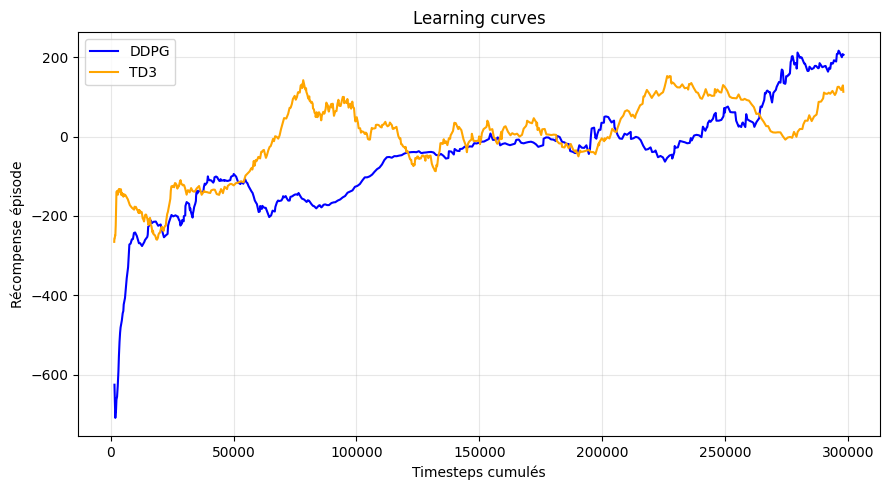

In [31]:
def load_single_monitor(path, episode_window=100, use_ema=False, alpha=0.05):
    df = pd.read_csv(path, skiprows=1)  # ligne JSON du header
    r = df["r"].to_numpy(dtype=float)
    l = df["l"].to_numpy(dtype=float)
    r = r[np.isfinite(r)]
    l = l[np.isfinite(l)]
    timesteps = np.cumsum(l)

    if use_ema:
        y = np.empty_like(r, dtype=float)
        y[0] = r[0]
        for i in range(1, len(r)):
            y[i] = alpha * r[i] + (1 - alpha) * y[i-1]
        return timesteps, y
    else:
        if episode_window <= 1 or len(r) < episode_window:
            return timesteps, r
        y = np.convolve(r, np.ones(episode_window)/episode_window, mode="valid")
        x = timesteps[episode_window-1:]
        return x, y

# Chemins vers tes fichiers uniques
ddpg_csv = r"./logs/ddpg_seed_0/monitor.csv"
td3_csv  = r"./logs/td3_seed_0/monitor.csv"

# Lissage: moyenne glissante (episode_window) ou EMA (use_ema=True)
episode_window = 20  # adapte à ton nb d’épisodes
use_ema = False      # mets True si tu préfères l’EMA

x1, y1 = load_single_monitor(ddpg_csv, episode_window=episode_window, use_ema=use_ema, alpha=0.05)
x2, y2 = load_single_monitor(td3_csv,  episode_window=episode_window, use_ema=use_ema, alpha=0.05)

plt.figure(figsize=(9,5))
if x1.size and y1.size:
    plt.plot(x1, y1, label="DDPG", color="blue")
if x2.size and y2.size:
    plt.plot(x2, y2, label="TD3",  color="orange")
plt.xlabel("Timesteps cumulés")
plt.ylabel("Récompense épisode")
plt.title("Learning curves")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Longueur episode

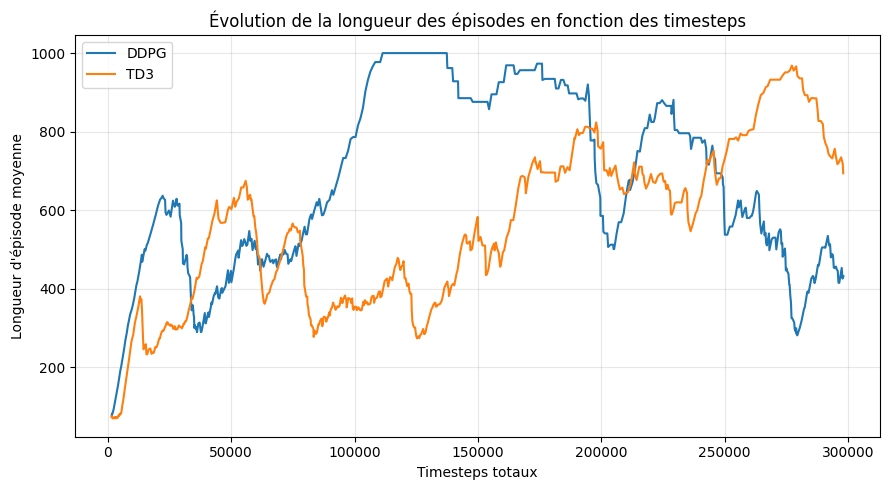

In [ ]:
def moving_average_ep(x, w):
    if w <= 1 or len(x) < w:
        return x
    return np.convolve(x, np.ones(w)/w, mode="valid")

def ema(x, alpha=0.05):
    if len(x) == 0: 
        return np.array([])
    y = np.empty_like(x, dtype=float)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = alpha*x[i] + (1-alpha)*y[i-1]
    return y

def load_lengths_monitor_vs_timesteps(path, episode_window=100, use_ema=False, alpha=0.05):
    df = pd.read_csv(path, skiprows=1)
    l = df["l"].to_numpy(dtype=float)   # longueurs d'épisodes
    l = l[np.isfinite(l)]

    # Axe X = cumul des steps
    timesteps = np.cumsum(l)

    # Lissage
    if use_ema:
        y = ema(l, alpha=alpha)
        x = timesteps
    else:
        y = moving_average_ep(l, episode_window)
        if episode_window > 1 and len(l) >= episode_window:
            x = timesteps[episode_window-1:]
        else:
            x = timesteps

    return x, y


# === Exemple d’utilisation ===
ddpg_csv = r"./logs/ddpg_seed_0/monitor.csv"
td3_csv  = r"./logs/td3_seed_0/monitor.csv"

episode_window = 20
use_ema = False

x1, y1 = load_lengths_monitor_vs_timesteps(ddpg_csv, episode_window=episode_window, use_ema=use_ema)
x2, y2 = load_lengths_monitor_vs_timesteps(td3_csv,  episode_window=episode_window, use_ema=use_ema)

plt.figure(figsize=(9,5))
if len(x1) and len(y1):
    plt.plot(x1, y1, label="DDPG", color="blue")
if len(x2) and len(y2):
    plt.plot(x2, y2, label="TD3", color="orange")

plt.xlabel("Timesteps totaux")
plt.ylabel("Longueur d'épisode moyenne")
plt.title("Évolution de la longueur des épisodes en fonction des timesteps")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# Visualisation de l'agent Pour DDPG

In [20]:
eval_env = gym.make("LunarLanderContinuous-v3", render_mode="human")

In [ ]:
model = DDPG.load("ddpg_LunarLanderContinuous-v3_seed_0")
obs, info = eval_env.reset()


for i in range(5000):
    action, _states = model.predict(obs)
    obs, rewards, dones, truncated,  info = eval_env.step(action)
    if dones:
        obs, info = eval_env.reset()
    
eval_env.close()

# Visualisation de l'agent Pour TD3

In [25]:
eval_env = gym.make("LunarLanderContinuous-v3", render_mode="human")

model = TD3.load("td3_LunarLanderContinuous-v3_seed_0")
obs, info = eval_env.reset()


for i in range(5000):
    action, _states = model.predict(obs)
    obs, rewards, dones, truncated,  info = eval_env.step(action)
    if dones:
        obs, info = eval_env.reset()

eval_env.close()
    